In [1]:
# Master jupyter notebook for Case Study

In [2]:
# importing libraries
import pandas as pd
import sqlite3
from sklearn.preprocessing import LabelEncoder
import datetime
from forex_python.converter import CurrencyRates
from forex_python.converter import RatesNotAvailableError
import plotly.express as px
import nbformat
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
import joblib
import numpy as np
import json


In [3]:
# extracting tables from database
def list_tables(database_file):
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    cursor.execute("""select name from sqlite_master where type = 'table';
                    """)
                    
    tables = cursor.fetchall()
    cursor.close()
    connection.close()
    table_names = [table[0] for table in tables]
    return table_names

# saving tables as dataframes
connection = sqlite3.connect('data.db')
query = """select *
        from client as cl;
        """
client = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from client_products as cl;
        """
client_products = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from balances as cl;
        """
balances = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from inv_campaign_eval as cl;
        """
inv_campaign_eval = pd.read_sql_query(query, connection)
connection.close

# merging tables with client data (excluding balances and campaign eval table)
connection = sqlite3.connect('data.db')
query = """
        select cl.client_id, age, job, marital, education, gender, has_deposits, loan, has_insurance, has_mortgage
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id
        --left join balances as ba on cl.client_id = ba.client_id
        --left join inv_campaign_eval as camp on cl.client_id = camp.client_id;
        """
clients_merged = pd.read_sql_query(query, connection)
connection.close

<function Connection.close()>

In [4]:
# checking for datatypes
print(clients_merged.dtypes)

# checking for missing values
print(client.isnull().sum()) # missing values in Age and Job
print(client_products.isnull().sum()) # no missing values
print(inv_campaign_eval.isnull().sum()) # no missing values
print(balances.isnull().sum()) # no missing values

# dealing with missing values
clients_merged['job'].fillna('unknown', inplace=True) # imputing "unknown" in job
clients_merged['age'].fillna(clients_merged['age'].median(), inplace=True) # imputing median in age

client_id          int64
age              float64
job               object
marital           object
education         object
gender            object
has_deposits      object
loan              object
has_insurance     object
has_mortgage      object
dtype: object
client_id      0
age          232
job          438
marital        0
education      0
gender         0
dtype: int64
client_id        0
has_deposits     0
loan             0
has_insurance    0
has_mortgage     0
dtype: int64
client_id    0
poutcome     0
dtype: int64
date         0
balance      0
client_id    0
currency     0
dtype: int64


In [5]:
# label encoding categorical variables
le = LabelEncoder()
clients_merged['has_deposits_enc'] = le.fit_transform(clients_merged['has_deposits'])
clients_merged['loan_enc'] = le.fit_transform(clients_merged['loan'])
clients_merged['has_insurance_enc'] = le.fit_transform(clients_merged['has_insurance'])
clients_merged['has_mortgage_enc'] = le.fit_transform(clients_merged['has_mortgage'])
clients_merged['marital_enc'] = le.fit_transform(clients_merged['marital'])
clients_merged['education_enc'] = le.fit_transform(clients_merged['education'])
clients_merged['gender_enc'] = le.fit_transform(clients_merged['gender'])
clients_merged['job_enc'] = le.fit_transform(clients_merged['job'])

In [6]:
# extracting encoding labels for future reference
job_labels = clients_merged[['job', 'job_enc']].drop_duplicates().sort_values('job_enc')
gender_labels = clients_merged[['gender', 'gender_enc']].drop_duplicates().sort_values('gender_enc')
education_labels = clients_merged[['education', 'education_enc']].drop_duplicates().sort_values('education_enc')
marital_labels = clients_merged[['marital', 'marital_enc']].drop_duplicates().sort_values('marital_enc')
has_mortgage_labels = clients_merged[['has_mortgage', 'has_mortgage_enc']].drop_duplicates().sort_values('has_mortgage_enc')
has_insurance_labels = clients_merged[['has_insurance', 'has_insurance_enc']].drop_duplicates().sort_values('has_insurance_enc')
loan_labels = clients_merged[['loan', 'loan_enc']].drop_duplicates().sort_values('loan_enc')
has_deposits_labels = clients_merged[['has_deposits', 'has_deposits_enc']].drop_duplicates().sort_values('has_deposits_enc')

In [7]:
# editing table balances
# removing time from datetime
balances['date'] = pd.to_datetime(balances['date'])
balances['date'] = balances['date'].dt.date

# fetching currency exchange rates for EUR and USD
c = CurrencyRates()

dates = balances['date'].drop_duplicates()
target_currency = 'CZK'

# EUR
base_currency = 'EUR'

eur_rates_date = []
eur_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    eur_rates_date.append(date)
    eur_rates_rate.append(rate)

eur_df = pd.DataFrame({'date': eur_rates_date, 'eur_rate': eur_rates_rate})

# USD
base_currency = 'USD'

usd_rates_date = []
usd_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    usd_rates_date.append(date)
    usd_rates_rate.append(rate)

usd_df = pd.DataFrame({'date': usd_rates_date, 'usd_rate': usd_rates_rate})

# mapping exchange rate columns into balances dataframe
balances = pd.merge(balances, eur_df, on = 'date')
balances = pd.merge(balances, usd_df, on = 'date')



In [8]:
# creating column with balances recalculated to czk
for index, row in balances.iterrows():
    if row['currency'] == 'EUR':
        balances.at[index, 'fx_rate'] = balances.at[index, 'eur_rate']
    elif row['currency'] == 'USD':
        balances.at[index, 'fx_rate'] = balances.at[index, 'usd_rate']
    else:
        balances.at[index, 'fx_rate'] = 1

balances['balance_in_czk'] = balances['balance']*balances['fx_rate']

In [9]:
# table balances: editing and feature engineering from variables: balance, currency
# encoding outcome variable 
inv_campaign_eval['poutcome_enc'] = le.fit_transform(inv_campaign_eval['poutcome'])

# last balance
last_timestamp_index = balances.groupby('client_id')['date'].idxmax()
last_timestamp_df = balances.loc[last_timestamp_index]
last_timestamp_df.rename(columns={'balance_in_czk': 'last_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, last_timestamp_df[['last_balance','client_id']], on = 'client_id')

# mean balance
mean_bal_by_client = balances.groupby('client_id')['balance_in_czk'].mean().reset_index()
mean_bal_by_client.rename(columns={'balance_in_czk': 'mean_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, mean_bal_by_client[['mean_balance','client_id']], on = 'client_id')

# min balance
min_bal_by_client = balances.groupby('client_id')['balance_in_czk'].min().reset_index()
min_bal_by_client.rename(columns={'balance_in_czk': 'min_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, min_bal_by_client[['min_balance','client_id']], on = 'client_id')

# max balance
max_bal_by_client = balances.groupby('client_id')['balance_in_czk'].max().reset_index()
max_bal_by_client.rename(columns={'balance_in_czk': 'max_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, max_bal_by_client[['max_balance','client_id']], on = 'client_id')

# currency (encoded)
clients_merged = pd.merge(clients_merged, balances[['client_id','currency']].drop_duplicates(), on = 'client_id')
clients_merged['currency_enc'] = le.fit_transform(clients_merged['currency'])
currency_labels = clients_merged[['currency', 'currency_enc']].drop_duplicates().sort_values('currency_enc')

In [10]:
# creating table first round of campaign - original columns (for visualizations)
first_round_vis = clients_merged[['client_id', 'age', 'job', 'marital', 'education', 'gender','has_deposits', 'loan', 'has_insurance', 'has_mortgage', 'last_balance','mean_balance', 'min_balance', 'max_balance', 'currency']]
first_round_vis = pd.merge(inv_campaign_eval[['client_id','poutcome']], first_round_vis, on = 'client_id')
first_round_vis['age'] = first_round_vis['age'].astype(int)

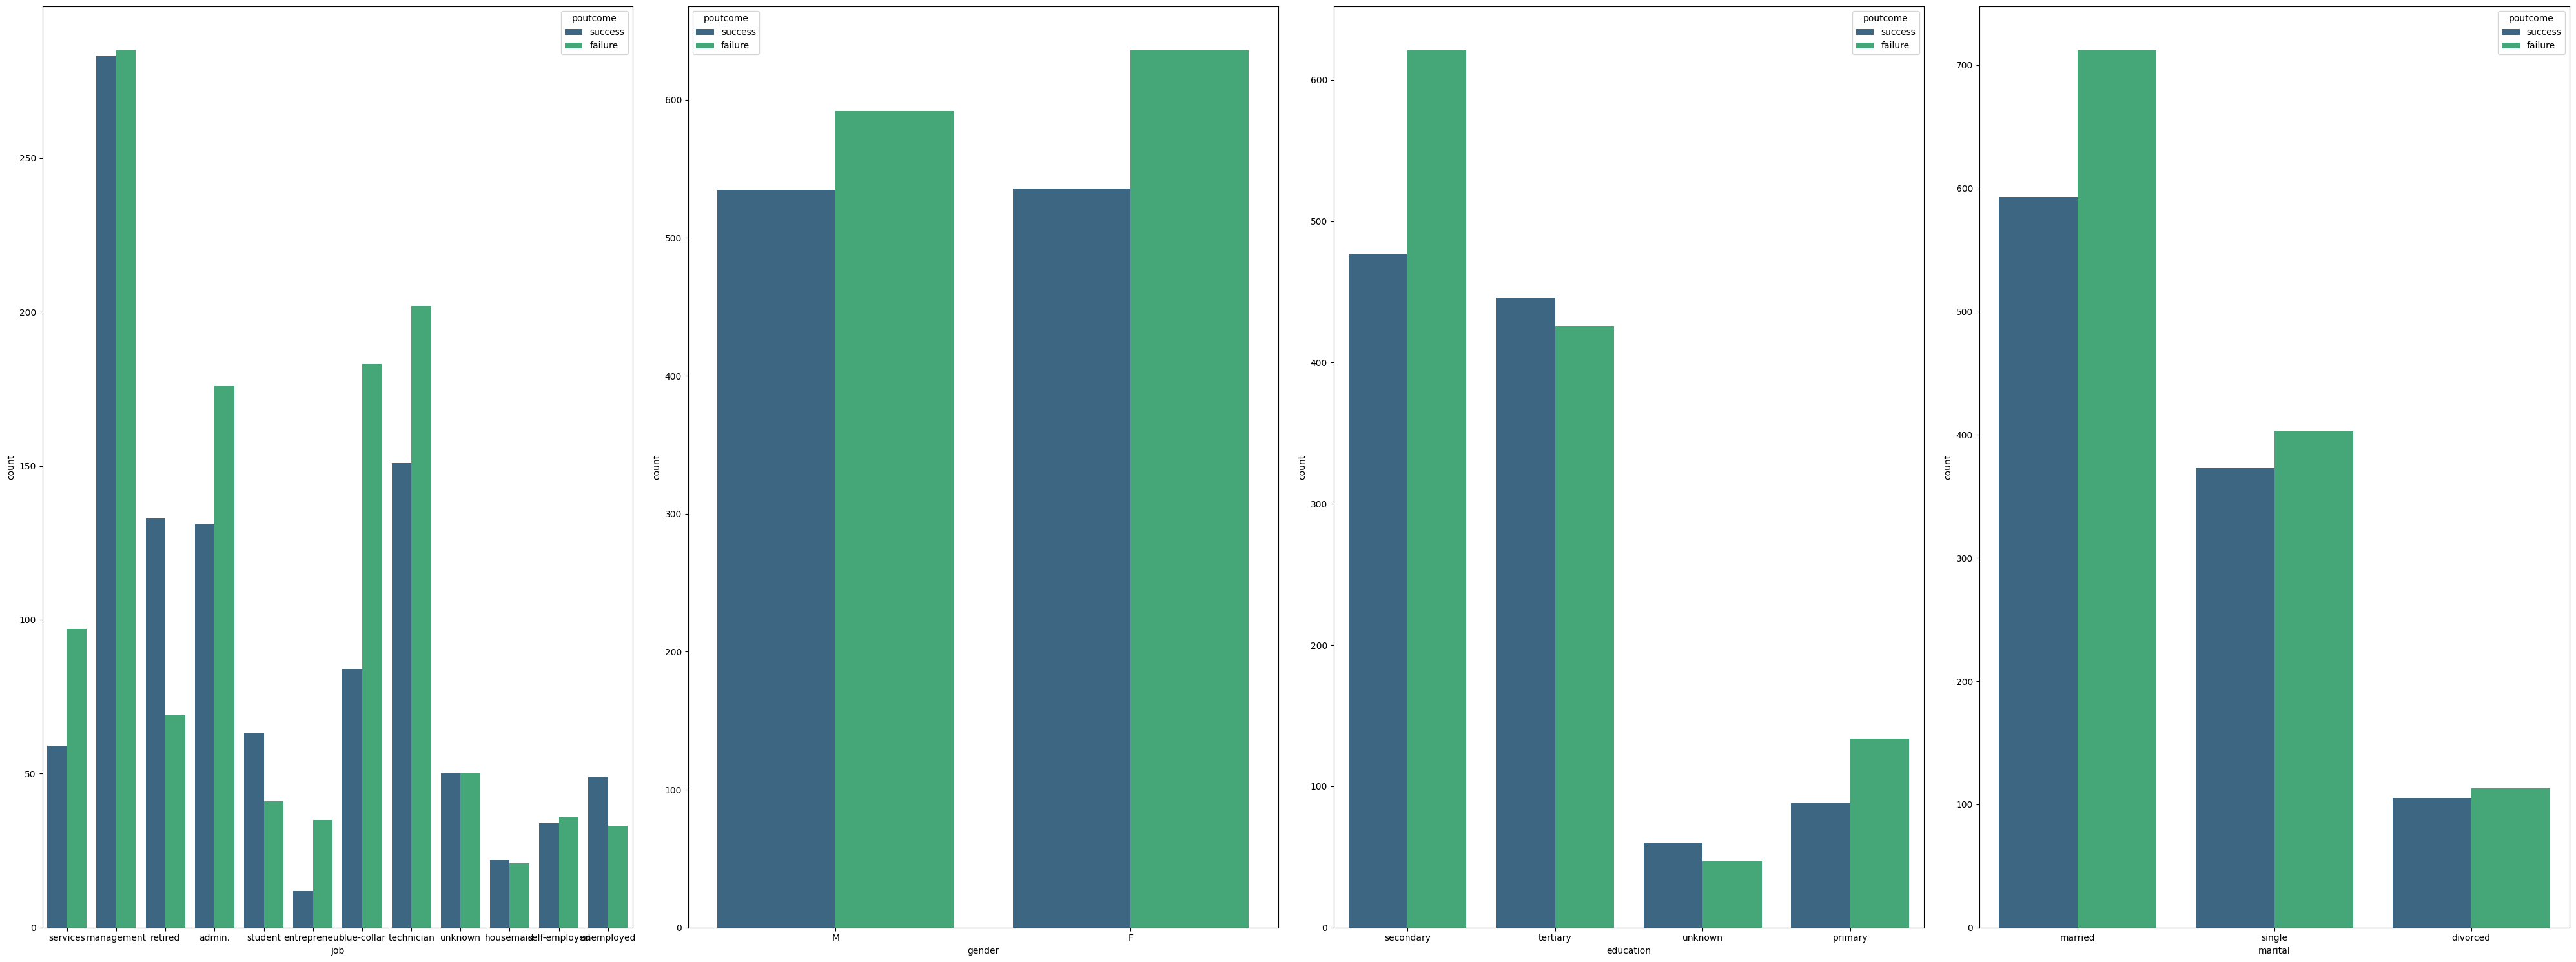

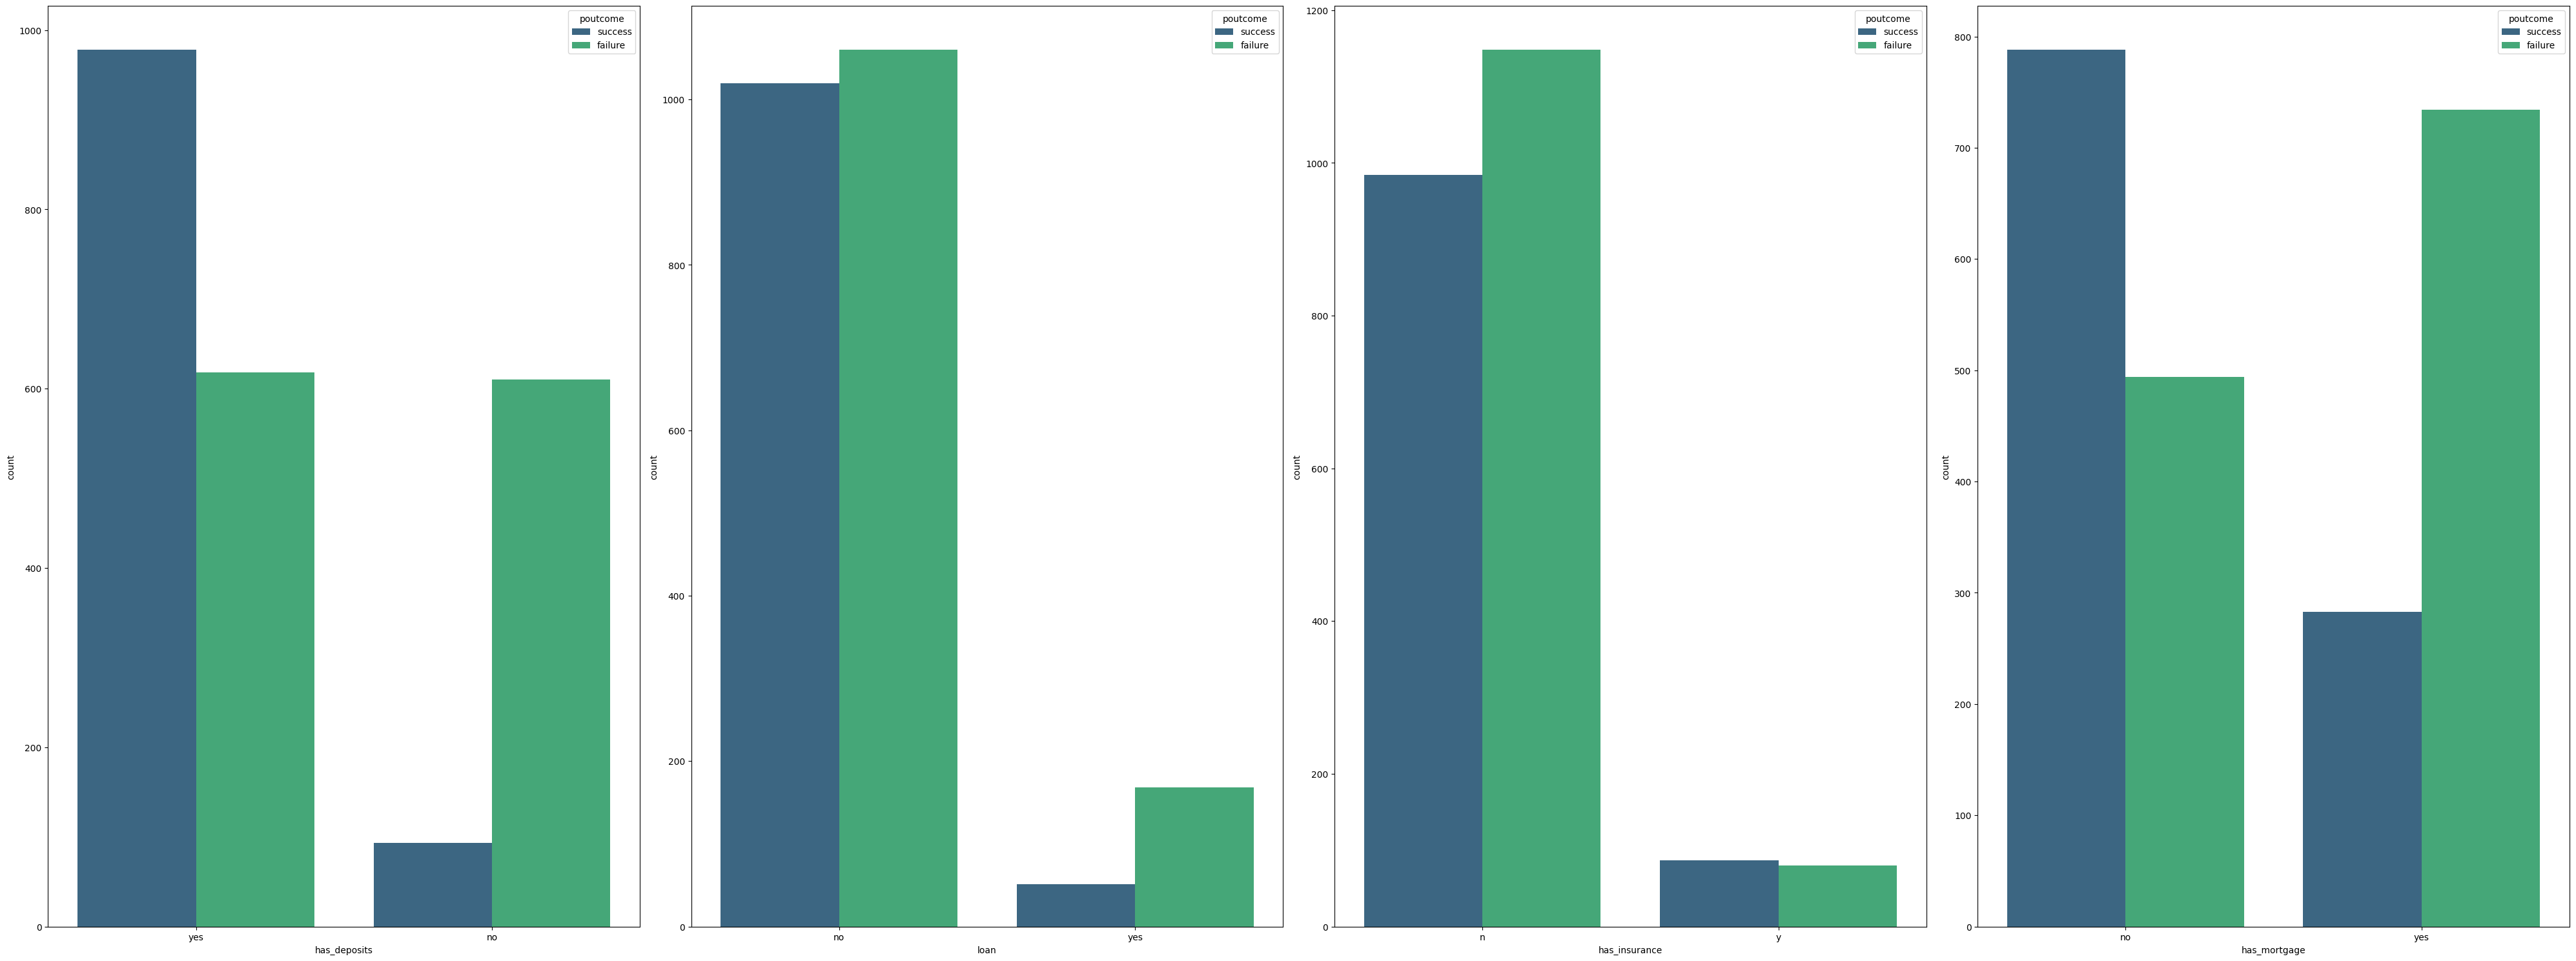

In [11]:
# visualizations of data from first round of campaign
# TO DO

plt.figure(figsize=(40, 15))

plt.subplot(1, 4, 1)
sns.countplot(x='job', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 2)
sns.countplot(x='gender', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 3)
sns.countplot(x='education', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 4)
sns.countplot(x='marital', hue='poutcome', data=first_round_vis, palette='viridis')

plt.tight_layout()
plt.show()
# ------------------------------------------------------------------------------------------
plt.figure(figsize=(40, 15))

plt.subplot(1, 4, 1)
sns.countplot(x='has_deposits', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 2)
sns.countplot(x='loan', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 3)
sns.countplot(x='has_insurance', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 4)
sns.countplot(x='has_mortgage', hue='poutcome', data=first_round_vis, palette='viridis')

plt.tight_layout()
plt.show()

In [12]:
# creating table first round of campaign - encoded columns (for modeling)
first_round_clients = clients_merged[['client_id', 'age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc','marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance','mean_balance', 'min_balance', 'max_balance', 'currency_enc']]
first_round_clients = pd.merge(inv_campaign_eval[['client_id','poutcome_enc']], first_round_clients, on = 'client_id')
first_round_clients['age'] = first_round_clients['age'].astype(int)

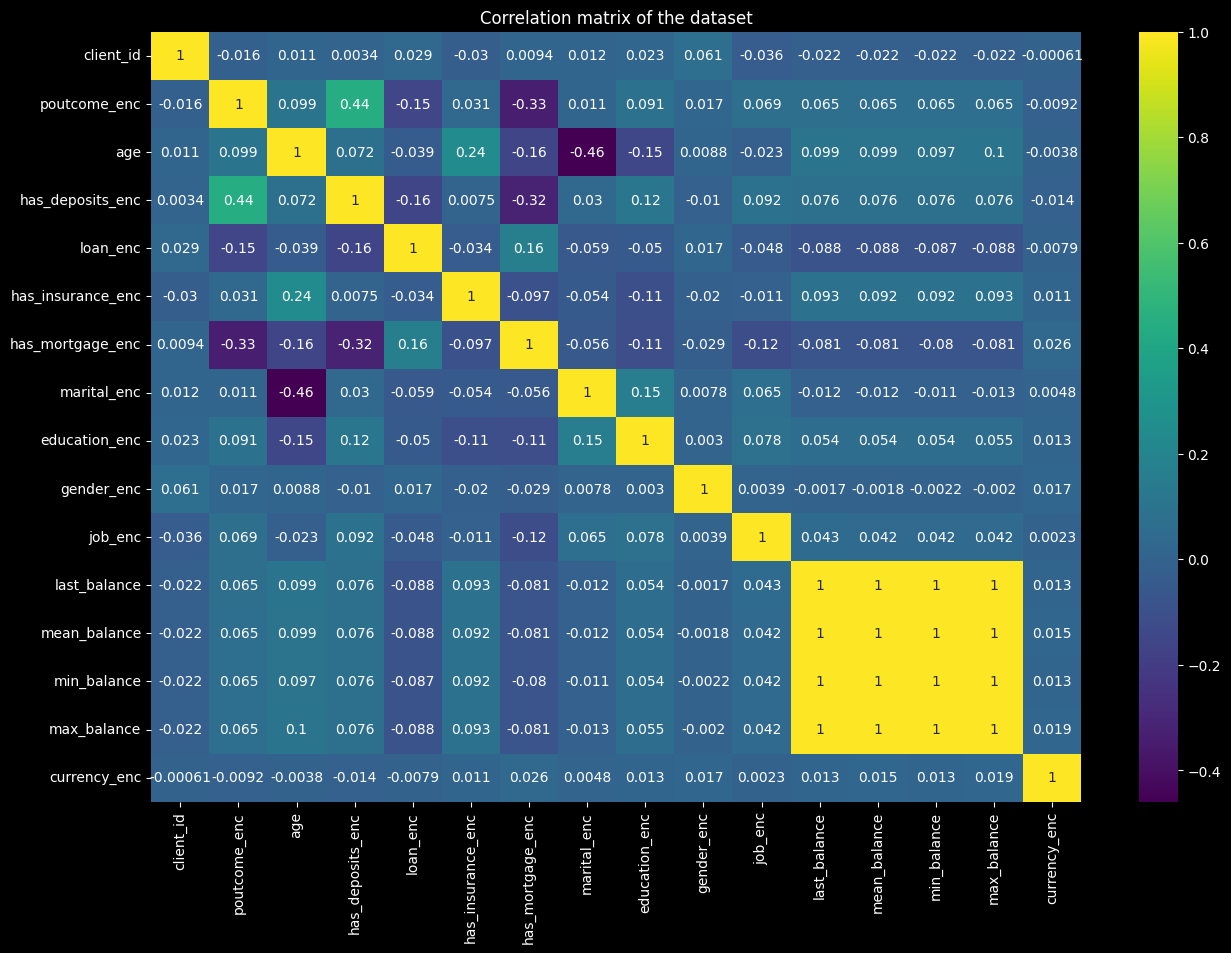

In [168]:
# Calculating the correlation matrix
corr = first_round_clients.corr()
# Plotting the correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='viridis')
plt.title('Correlation matrix of the dataset')
plt.show()

In [13]:
# creating X-matrix of predictors and y-outcome variable
X = first_round_clients.drop(['client_id','poutcome_enc'], axis = 1)
y = first_round_clients['poutcome_enc']

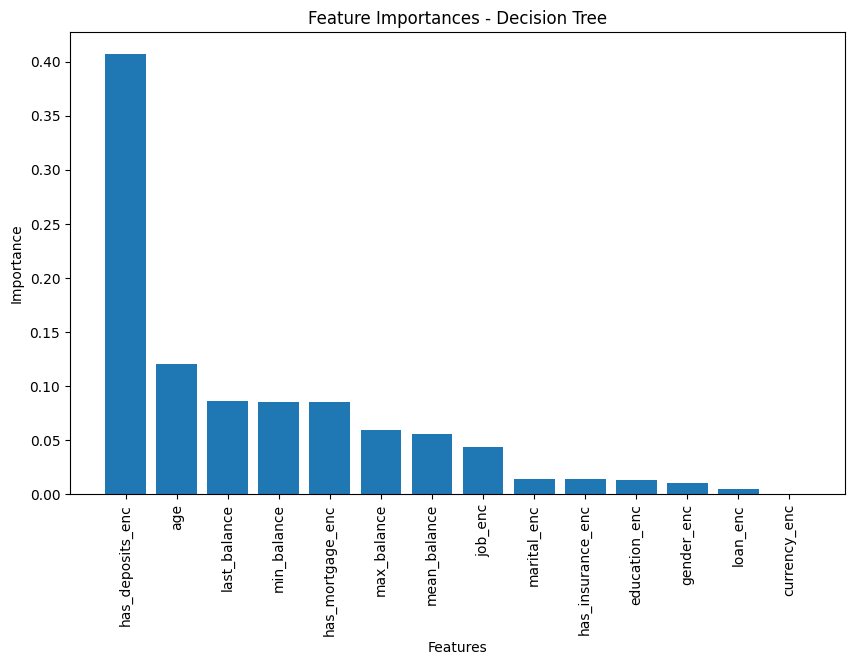

In [14]:
# selecting most important features from X using feature importance
classifier = DecisionTreeClassifier(max_depth=10, min_samples_split=4)

classifier.fit(X, y)
importances = classifier.feature_importances_
feature_names = ['age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc',
                     'marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance',
                     'mean_balance', 'min_balance', 'max_balance', 'currency_enc']

sorted_data = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse = True)
sorted_feature_names, sorted_importances = zip(*sorted_data)

# Set dark theme
plt.style.use('dark_background')
# Set custom rcParams for dark theme
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

plt.figure(figsize=(10, 6))
plt.title('Feature Importances - Decision Tree')
plt.bar(sorted_feature_names, sorted_importances, align="center")
plt.xticks(sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# based on decision tree and feature importances, we consider as most important these variables:
# 'has_deposits_enc', 'age', 'last_balance','min_balance', 'has_mortgage_enc','max_balance','mean_balance','job_enc'
X = X[['has_deposits_enc', 'age', 'last_balance','min_balance', 'has_mortgage_enc','max_balance','mean_balance','job_enc']]

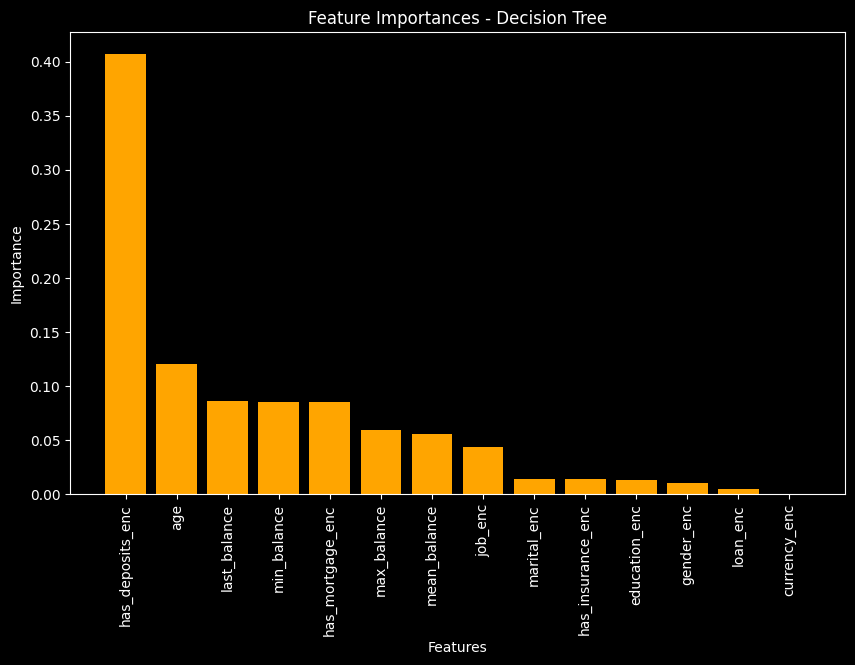

In [154]:
# Set dark theme
plt.style.use('dark_background')
# Set custom rcParams for dark theme
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

plt.figure(figsize=(10, 6))
plt.title('Feature Importances - Decision Tree')
plt.bar(sorted_feature_names, sorted_importances, align="center", color = 'orange')
plt.xticks(sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [15]:
# performing train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [16]:
# Logistic Regression
# Define the Logistic Regression model
logistic_classifier = LogisticRegression()

# Define the hyperparameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=logistic_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_sc, y_train)

# Get the best estimator
best_lr_estimator = grid_search.best_estimator_


c:\DANIELA\Data_Science_Bootcamp\case_study\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\DANIELA\Data_Science_Bootcamp\case_study\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\DANIELA\Data_Science_Bootcamp\case_study\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\DANIELA\Data_Science_Bootcamp\case_study\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\DANIELA\Data_Science_Bootcamp\case_study\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

In [17]:
# KNN
# Define the KNN classifier
knn_classifier = KNeighborsClassifier()

# Define the hyperparameter grid to search over
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_sc, y_train)

# Get the best estimator
best_knn_estimator = grid_search.best_estimator_


In [18]:
# Random Forest
# Define the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [None, 2, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_sc, y_train)

# Get the best estimator
best_rf_estimator = grid_search.best_estimator_

In [19]:
# Adaboost
# Define the Adaboost classifier
adaboost = AdaBoostClassifier()

# Define the hyperparameter grid to search over
adaboost_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

# Create GridSearchCV object
grid_search = GridSearchCV(adaboost, adaboost_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_sc, y_train)

# Get the best estimator
best_adaboost_estimator = grid_search.best_estimator_


In [29]:
# Neural Network
nn = Sequential([
    Input(shape = (8,)),
    Dense(32, activation = "tanh"),
    Dense(32, activation = "tanh"),
    Dense(1, activation = "sigmoid")

])

nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

history = nn.fit(X_train_sc, y_train, epochs=100, batch_size=32, verbose = 0, validation_split=0.1)

# manually calculating metrics for test data
y_pred_nn_test = nn.predict(X_test_sc)
y_pred_binary_test = (y_pred_nn_test > 0.5).astype(int)
f1_nn = f1_score(y_test, y_pred_binary_test)

roc_auc_nn = roc_auc_score(y_test, y_pred_nn_test)

precision_nn, recall_nn, _nn = precision_recall_curve(y_test, y_pred_nn_test)
pr_auc_nn = auc(recall_nn, precision_nn)

acc_nn_test = accuracy_score(y_test, y_pred_binary_test)

# manually calculating metrics for train data
y_pred_nn_train = nn.predict(X_train_sc)
y_pred_binary_train = (y_pred_nn_train > 0.5).astype(int)
f1_nn_train = f1_score(y_train, y_pred_binary_train)

roc_auc_nn_train = roc_auc_score(y_train, y_pred_nn_train)

precision_nn, recall_nn, _nn = precision_recall_curve(y_train, y_pred_nn_train)
pr_auc_nn_train = auc(recall_nn, precision_nn)

acc_nn_train = accuracy_score(y_train, y_pred_binary_train)

51/51 [==============================] - 0s 1ms/step


In [86]:
# run on Test data - compare models on F1, AUC - choose best model

classifiers = [best_rf_estimator, best_lr_estimator, best_knn_estimator, best_adaboost_estimator]
classifier_names = ['Random Forest', 'Logistic Regression', 'KNN', 'Adaboost']

# Define metrics
metrics = {'F1 Score': f1_score, 'AUC-ROC': roc_auc_score}

# Collect results
results_on_test = {}

for classifier, name in zip(classifiers, classifier_names):
    # F1 Score
    y_pred = classifier.predict(X_test_sc)
    f1 = f1_score(y_test, y_pred)
    
    # AUC-ROC
    y_scores = classifier.predict_proba(X_test_sc)[:, 1]
    roc_auc = roc_auc_score(y_test, y_scores)
    
    # AUC-PR
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    results_on_test[name] = {'F1 Score': f1, 'AUC-ROC': roc_auc, 'AUC-PR': pr_auc, 'Accuracy': accuracy,'y_scores': y_scores}

results_on_test['Neural network'] = {'F1 Score': f1_nn, 'AUC-ROC': roc_auc_nn, 'AUC-PR': pr_auc_nn, 'Accuracy': acc_nn_test, 'y_scores': y_pred_nn_test}

# Print results
for name, metrics_dict in results_on_test.items():
    print(f"\n{name} Metrics:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")

# printing metrics results
results_on_test_metrics = pd.DataFrame(results_on_test).iloc[0:4,:]



Random Forest Metrics:
F1 Score: 0.6719242902208201
AUC-ROC: 0.7489855954554676
AUC-PR: 0.6551377546732486
Accuracy: 0.6985507246376812
y_scores: [0.58219598 0.54469183 0.61534236 0.59178956 0.50890778 0.34073552
 0.26602721 0.44834981 0.64927771 0.26851645 0.48489057 0.59838066
 0.57596129 0.24047291 0.59290651 0.24047291 0.46962086 0.60597088
 0.46453449 0.48580554 0.60281405 0.4833163  0.47888487 0.59838066
 0.32669989 0.5994976  0.4833163  0.59838066 0.26851645 0.46634309
 0.39725143 0.58548054 0.47021014 0.3161592  0.59415528 0.26851645
 0.6296649  0.59838066 0.27170937 0.24832528 0.24862618 0.61678736
 0.27419861 0.30886523 0.60517976 0.59838066 0.59838066 0.60623303
 0.49788329 0.26851645 0.22932686 0.3161592  0.40421854 0.60372299
 0.59858867 0.34702373 0.57888945 0.2805942  0.5779706  0.3569202
 0.58756418 0.48169861 0.49003092 0.59838066 0.59415528 0.22732806
 0.59415528 0.5732138  0.25430182 0.23624753 0.24256284 0.47918857
 0.46069088 0.5994976  0.3569202  0.60940515 0.246

In [31]:
# Collect results on train data
results_on_train = {}

for classifier, name in zip(classifiers, classifier_names):
    # F1 Score
    y_pred = classifier.predict(X_train_sc)
    f1_train = f1_score(y_train, y_pred)
    
    # AUC-ROC
    y_scores_train = classifier.predict_proba(X_train_sc)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_scores_train)
    
    # AUC-PR
    precision, recall, _ = precision_recall_curve(y_train, y_scores_train)
    pr_auc_train = auc(recall, precision)

    # Accuracy
    accuracy = accuracy_score(y_train, y_pred)
    
    results_on_train[name] = {'F1 Score': f1_train, 'AUC-ROC': roc_auc_train, 'AUC-PR': pr_auc_train, 'Accuracy': accuracy, 'y_scores': y_scores_train}

results_on_train['Neural network'] = {'F1 Score': f1_nn_train, 'AUC-ROC': roc_auc_nn_train, 'AUC-PR': pr_auc_nn_train, 'Accuracy': acc_nn_train,'y_scores': y_pred_nn_train}

# printing metrics results
results_on_train_metrics = pd.DataFrame(results_on_train).iloc[0:4,:]


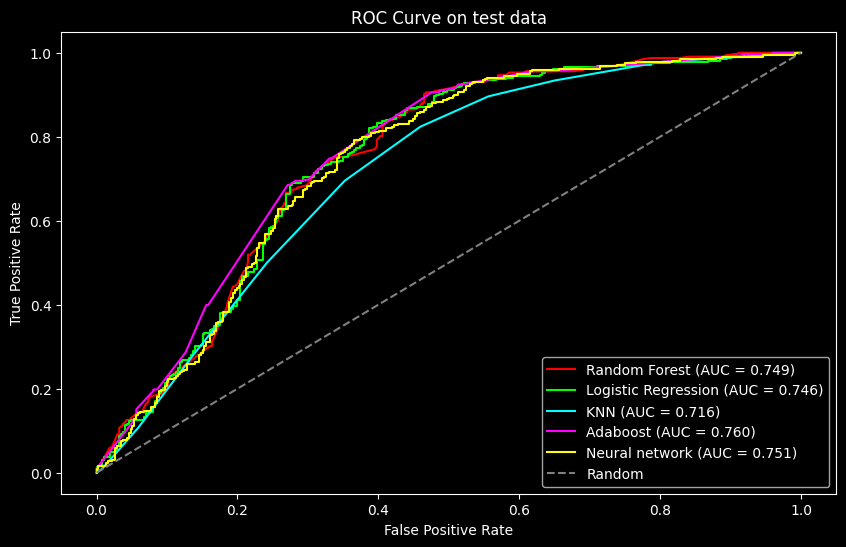

In [164]:
# ROC Curve on test
#classifiers = [best_rf_estimator, best_lr_estimator, best_knn_estimator, best_adaboost_estimator, nn]
#classifier_names = ['Random Forest', 'Logistic Regression', 'KNN', 'Adaboost', 'Neural network']

# Set dark theme
plt.style.use('dark_background')
# Set custom rcParams for dark theme
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

plt.figure(figsize=(10, 6))

line_colors = ['red', 'lime', 'cyan', 'magenta', 'yellow']

for classifier, name, color in zip(classifiers, classifier_names, line_colors):
    fpr, tpr, _ = roc_curve(y_test, results_on_test[name]['y_scores'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results_on_test[name]['AUC-ROC']:.3f})", color=color)

plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve on test data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


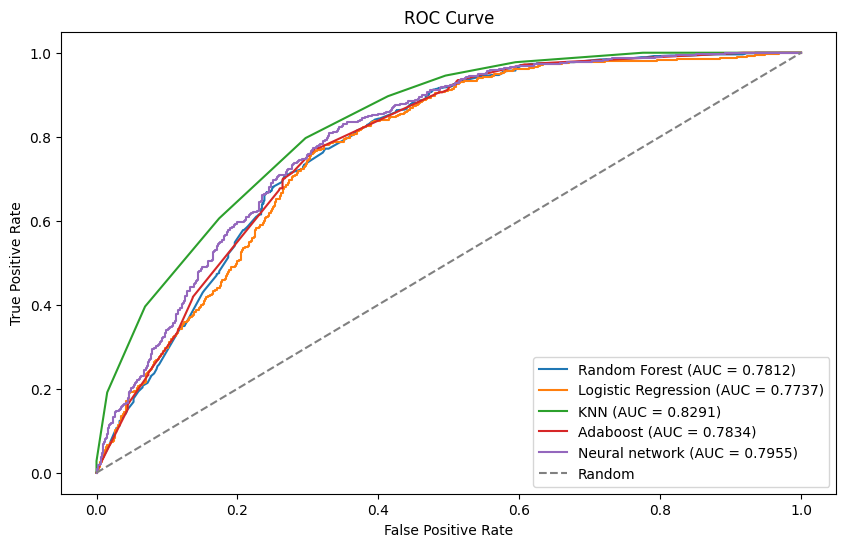

In [25]:
# ROC Curve on train
classifiers = [best_rf_estimator, best_lr_estimator, best_knn_estimator, best_adaboost_estimator, nn]
classifier_names = ['Random Forest', 'Logistic Regression', 'KNN', 'Adaboost', 'Neural network']

plt.figure(figsize=(10, 6))
for classifier, name in zip(classifiers, classifier_names):
    fpr, tpr, _ = roc_curve(y_train, results_on_train[name]['y_scores'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results_on_train[name]['AUC-ROC']:.4f})")

plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [160]:
results_on_test_metrics.applymap(lambda x: round(x, 3))

C:\Users\Danielka\AppData\Local\Temp\ipykernel_17060\876586444.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_on_test_metrics.applymap(lambda x: round(x, 3))


,Random Forest,Logistic Regression,KNN,Adaboost,Neural network
F1 Score,0.672,0.679,0.660,0.681,0.693
AUC-ROC,0.749,0.746,0.716,0.760,0.751
AUC-PR,0.655,0.646,0.610,0.681,0.642
Accuracy,0.699,0.700,0.670,0.699,0.696


In [33]:

results_on_train_metrics

,Random Forest,Logistic Regression,KNN,Adaboost,Neural network
F1 Score,0.691892,0.693527,0.746733,0.703728,0.729746
AUC-ROC,0.781189,0.773729,0.829109,0.783379,0.79685
AUC-PR,0.700869,0.695897,0.800771,0.707119,0.735921
Accuracy,0.716594,0.711622,0.747048,0.718459,0.728403


In [82]:
# editing data of clients not included in first run
# preparing data for second round of campaign
second_round_ids = clients_merged.loc[~clients_merged['client_id'].isin(inv_campaign_eval['client_id']), 'client_id']
clients_merged_second = clients_merged[clients_merged['client_id'].isin(second_round_ids)]
second_X = clients_merged_second[['has_deposits_enc', 'age', 'last_balance', 'min_balance', 'has_mortgage_enc', 'max_balance', 'mean_balance', 'job_enc']]

second_X_sc = scaler.transform(second_X)

In [83]:
# run best model on data not included in first run - output predict_proba - select 3000 ids
second_y_pred = best_lr_estimator.predict_proba(second_X_sc)[:,1]

id_results = {'client_id': second_round_ids, 'y_proba': second_y_pred}
id_results = pd.DataFrame(id_results)

id_results_3000 = id_results.sort_values('y_proba', ascending=False).head(3000)
clients_3000 = pd.merge(id_results_3000, clients_merged, on = 'client_id')

In [101]:
# calculate expected number of successes (client will in fact invest in our product)
ex_success = id_results_3000['y_proba'].sum()

# calculate expected revenue for different amounts of investment
ex_rev_5000 = sum(5000*clients_3000['y_proba'])
ex_rev_2000 = sum(2000*clients_3000['y_proba'])

print(ex_success, ex_rev_5000, ex_rev_2000)

1930.0696164032038 9650348.082016028 3860139.2328064074


In [92]:
#second_phase_outcome = pd.read_csv('second_phase_target_labeled.csv')[['client_id','poutcome']]
#clients_3000 = pd.read_csv('clients_3000.csv')

In [117]:
clients_8800 = pd.merge(id_results, clients_merged, on = 'client_id')
df_sample = clients_8800.sample(n=3000, random_state=42)

ex_successs = df_sample['y_proba'].sum()
print(ex_successs)

print(ex_success)

pocet = second_phase_outcome['poutcome'].sum()
pocet/ex_success*ex_successs

1007.5814596242892
1930.0696164032038


719.3767725071608

In [144]:
clients_8800

,client_id,y_proba,age,job,marital,education,gender,has_deposits,loan,has_insurance,...,marital_enc,education_enc,gender_enc,job_enc,last_balance,mean_balance,min_balance,max_balance,currency,currency_enc
0,1222646323,0.227109,46.0,services,divorced,unknown,M,no,no,n,...,0,3,1,7,1005.302876,960.562073,886.126906,1054.517907,CZK,0
1,451375919,0.084436,33.0,admin.,single,secondary,F,no,no,n,...,2,1,0,0,1100.917203,1221.016419,1100.917203,1303.494818,CZK,0
2,338972671,0.090614,44.0,self-employed,married,secondary,F,no,no,y,...,1,1,0,6,357.676547,297.993265,202.053088,446.676191,CZK,0
3,1472834688,0.438715,36.0,blue-collar,married,primary,M,yes,no,n,...,1,0,1,1,1906.382731,1919.318145,1853.387429,2011.939205,CZK,0
4,1068680340,0.508028,63.0,admin.,married,secondary,F,yes,no,n,...,1,1,0,0,27.197528,0.972130,-104.261740,77.806737,CZK,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8858,440873221,0.249281,56.0,management,divorced,tertiary,F,no,no,n,...,0,2,0,4,412.546184,386.995526,270.665696,469.647273,CZK,0
8859,543198889,0.088576,40.0,blue-collar,single,unknown,M,no,no,n,...,2,3,1,1,5.538113,18.441905,-98.265981,125.568092,CZK,0
8860,458558558,0.088982,41.0,housemaid,divorced,primary,F,no,no,n,...,0,0,0,3,70.463701,25.552707,-117.991255,116.816943,CZK,0
8861,1426334329,0.112608,59.0,technician,married,primary,F,no,no,y,...,1,0,0,9,3232.008038,3157.720202,3024.384824,3263.371390,CZK,0


In [142]:
# Exporting semi results into csv

# csv_file_path = 'id_results.csv'
# id_results.to_csv(csv_file_path, index=False)

# csv_file_path = 'clients_3000.csv'
# clients_3000.to_csv(csv_file_path, index=False)

# joblib.dump(scaler, 'standard_scaler.joblib')

# joblib.dump(best_rf_estimator, 'best_rf_estimator.joblib')
# joblib.dump(best_lr_estimator, 'best_lr_estimator.joblib')
# joblib.dump(best_knn_estimator, 'best_knn_estimator.joblib')
# joblib.dump(best_adaboost_estimator, 'best_adaboost_estimator.joblib')
# joblib.dump(nn, 'nn.joblib')

# np.save('X_test_sc.npy', X_test_sc)
# np.save('X_train_sc.npy', X_train_sc)

# X_test.to_csv('X_test.csv', index=False)
# X_train.to_csv('X_train.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)

# results_on_train_metrics.to_csv('results_on_train_metrics.csv', index=False)
# results_on_test_metrics.to_csv('results_on_test_metrics.csv', index=False)

# y_scores_nn_train = results_on_train['Neural network']['y_scores'].flatten()
# y_scores_rf_train = results_on_train['Random Forest']['y_scores']
# y_scores_lr_train = results_on_train['Logistic Regression']['y_scores']
# y_scores_knn_train = results_on_train['KNN']['y_scores']
# y_scores_adaboost_train = results_on_train['Adaboost']['y_scores']

# y_scores_nn_test = results_on_test['Neural network']['y_scores'].flatten()
# y_scores_rf_test = results_on_test['Random Forest']['y_scores']
# y_scores_lr_test = results_on_test['Logistic Regression']['y_scores']
# y_scores_knn_test = results_on_test['KNN']['y_scores']
# y_scores_adaboost_test = results_on_test['Adaboost']['y_scores']

# np.save('y_scores_nn_train.npy', y_scores_nn_train)
# np.save('y_scores_rf_train.npy', y_scores_rf_train)
# np.save('y_scores_lr_train.npy', y_scores_lr_train)
# np.save('y_scores_knn_train.npy', y_scores_knn_train)
# np.save('y_scores_adaboost_train.npy', y_scores_adaboost_train)

# np.save('y_scores_nn_test.npy', y_scores_nn_test)
# np.save('y_scores_rf_test.npy', y_scores_rf_test)
# np.save('y_scores_lr_test.npy', y_scores_lr_test)
# np.save('y_scores_knn_test.npy', y_scores_knn_test)
# np.save('y_scores_adaboost_test.npy', y_scores_adaboost_test)
